C:\Users\ilyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\ilyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\ilyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 12 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\ilyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\ilyas\AppData\Loc

Таблица с результатами вычисления числа Pi с использованием CPU и GPU:
   Число точек  Pi (CPU)  Время (CPU)  Pi (GPU)  Время (GPU)  Ускорение
0         1000  3.156000     0.001008  3.072000     0.596465   0.001690
1         2000  3.126000     0.001991  3.192000     0.002523   0.789021
2         3000  3.164000     0.002992  3.177333     0.002990   1.000478
3         4000  3.181000     0.004514  3.181000     0.001992   2.265949
4         5000  3.101600     0.004986  3.118400     0.002590   1.924620
5         6000  3.144000     0.007578  3.141333     0.002522   3.005105
6         7000  3.128571     0.008969  3.146286     0.000522  17.185930
7         8000  3.141000     0.013033  3.157000     0.001983   6.570982
8         9000  3.155111     0.011014  3.150222     0.001996   5.519355
9        10000  3.155600     0.013036  3.115600     0.000999  13.042700


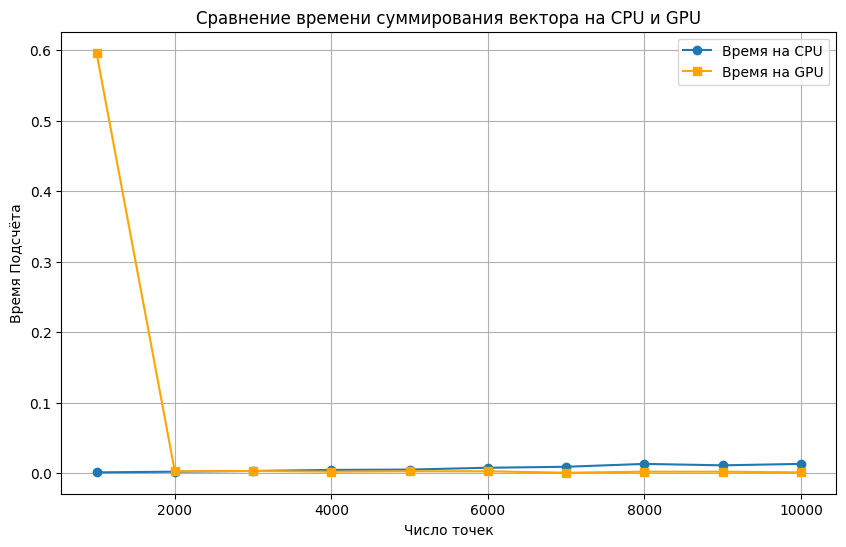

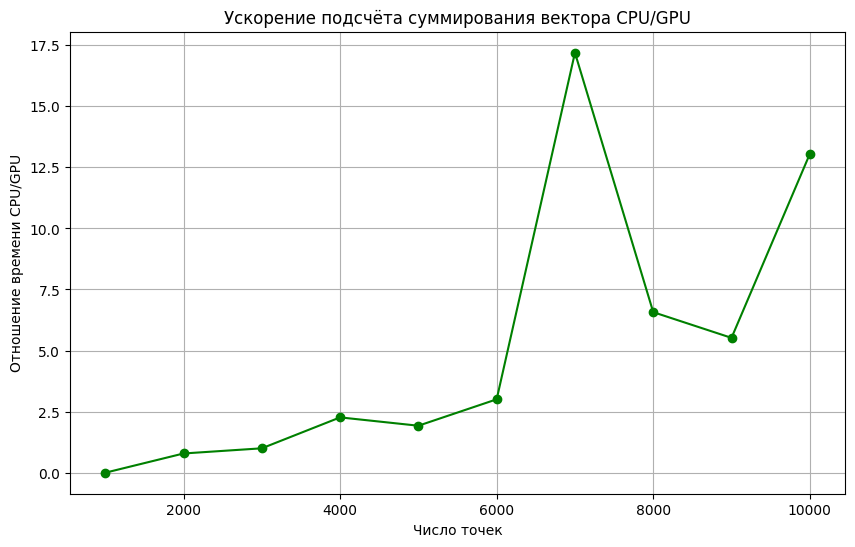

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from numba import cuda, float32
import pandas as pd
     
#CPU
def mc_cpu(N):
    count = 0
    for i in range(N):
        x, y = np.random.random(), np.random.random()
        if x*x + y*y < 1.0:
            count += 1
    return 4.0 * count / N

#CUDA
@cuda.jit
def mc_gpu_kernel(x, y, results):
    idx = cuda.grid(1)
    if idx < x.size:
        if x[idx]**2 + y[idx]**2 < 1.0:
            results[idx] = 1
        else:
            results[idx] = 0

def mc_gpu(N):
    x = np.random.random(N).astype(np.float32)
    y = np.random.random(N).astype(np.float32)

    cuda_x = cuda.to_device(x)
    cuda_y = cuda.to_device(y)
    results = cuda.device_array(N, dtype=np.int32)

    threads_per_block = 256
    blocks_per_grid = (N + (threads_per_block - 1)) // threads_per_block

    mc_gpu_kernel[blocks_per_grid, threads_per_block](cuda_x, cuda_y, results)

    count = results.copy_to_host().sum()
    return 4.0 * count / N

N = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
results = {
    'Число точек': [],
    'Pi (CPU)': [],
    'Время (CPU)': [],
    'Pi (GPU)': [],
    'Время (GPU)': [],
    'Ускорение': []
}

for i in N:
    start_cpu = time.time()
    pi_cpu = mc_cpu(i)
    time_cpu = time.time() - start_cpu

    start_gpu = time.time()
    pi_gpu = mc_gpu(i)
    time_gpu = time.time() - start_gpu
    
    speedup = time_cpu / time_gpu

    results["Число точек"].append(i)
    results["Время (CPU)"].append(time_cpu)
    results["Время (GPU)"].append(time_gpu)
    results["Pi (CPU)"].append(pi_cpu)
    results["Pi (GPU)"].append(pi_gpu)
    results["Ускорение"].append(speedup)
    
print("Таблица с результатами вычисления числа Pi с использованием CPU и GPU:")
df_results = pd.DataFrame(results)
print(df_results)

##############
plt.figure(figsize=(10, 6))
plt.plot(df_results["Число точек"], df_results["Время (CPU)"], 'o-', label='Время на CPU')
plt.plot(df_results["Число точек"], df_results["Время (GPU)"], 's-', label='Время на GPU', color='orange')

plt.xlabel('Число точек')
plt.ylabel('Время Подсчёта')
plt.title('Сравнение времени суммирования вектора на CPU и GPU')
plt.grid(True)
plt.legend()
plt.show()

#Ускорение
plt.figure(figsize=(10, 6))
plt.plot(df_results["Число точек"], df_results["Ускорение"], 'o-', label='Ускорение', color='green')
plt.xlabel("Число точек")
plt.ylabel('Отношение времени CPU/GPU')
plt.title('Ускорение подсчёта суммирования вектора CPU/GPU')
plt.grid(True)


plt.show()